# Import


In [51]:
# Standard Libraries
import random
import numpy as np
import pandas as pd
import warnings

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Modules
from bar_plot import plot_name_values
from pre_processing_image import resize_images

# Scikit-learn Modules
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, confusion_matrix, log_loss, precision_score, recall_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier

In [52]:
image_shape = (28, 28, 3)

# Preprocessing

In [53]:
parent_names = ["Testing", "Training"]
output_csvs = ["test.csv", "train.csv"]
resize_images(parent_names, output_csvs, image_shape[:2])

# Prepare

In [54]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [55]:
Y_train = train["label"]
Y_test = test["label"]
X_train = train.drop(labels=["label"], axis=1)
X_test = test.drop(labels=["label"], axis=1)
print("X_train shape is: ", X_train.shape)
print("X_test shape is: ", X_test.shape)

X_train shape is:  (1731, 2352)
X_test shape is:  (1012, 2352)


In [56]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()

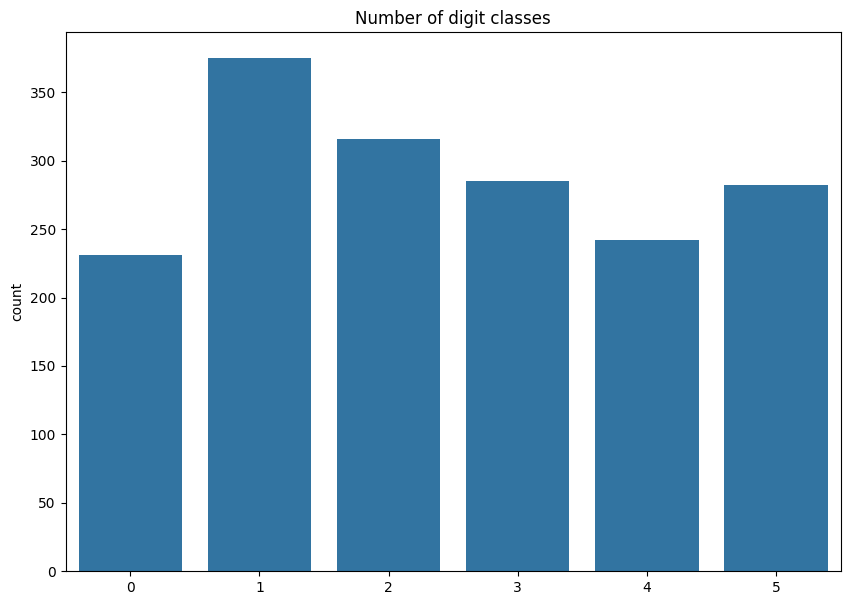

In [57]:
plt.figure(figsize=(10, 7))
sns.countplot(x=Y_train)
plt.title("Number of digit classes")
plt.show()

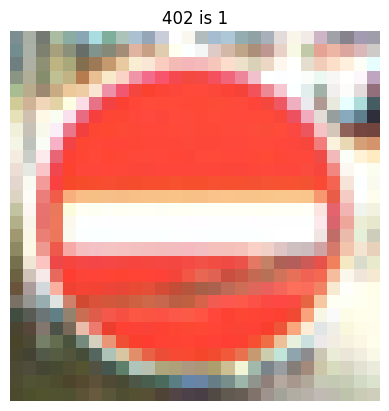

In [58]:
random_index = random.randint(0, X_train.shape[0])
img = X_train[random_index]
img = img.reshape(image_shape)
plt.imshow(img, cmap='gray')
plt.title(f"{random_index} is {Y_train[random_index]}")
plt.axis("off")
plt.show()

# KNN for image

In [59]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [60]:
k = 7
knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
knn.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=7)

In [61]:
Y_pred = knn.predict(X_test)

# Logistic for image

In [62]:
images, labels = train.drop(labels=["label"], axis=1), train["label"]

print(images.shape, labels.shape)

(1731, 2352) (1731,)


In [63]:
flat_images = np.array(images)
target = np.array(labels)

In [64]:
df = pd.DataFrame(flat_images)

df['Target'] = target

x_train = df.iloc[:, :-1]

y_train = df.iloc[:, -1]

In [65]:
images, labels = test.drop(labels=["label"], axis=1), test["label"]

In [66]:
flat_test_images = np.array(images)
test_target = np.array(labels)

In [67]:
df = pd.DataFrame(flat_test_images)
df['Target'] = test_target

x_test = df.iloc[:, :-1]

y_test = df.iloc[:, -1]

In [68]:
model = LogisticRegression(solver='liblinear')

history = model.fit(x_train, y_train)

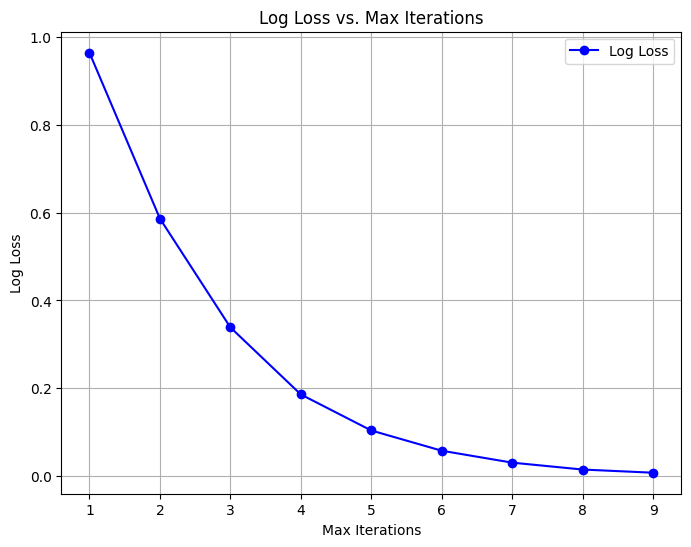

In [69]:
losses = []
warnings.filterwarnings("ignore")
for i in range(1, 10):
    modelFake = LogisticRegression(solver='liblinear', max_iter=i)

    modelFake.fit(x_train, y_train)

    x_train_pred_proba = modelFake.predict_proba(x_train)

    losses.append(log_loss(y_train, x_train_pred_proba))


plt.figure(figsize=(8, 6))
plt.plot(range(1, 10), losses, marker='o',
         linestyle='-', color='b', label='Log Loss')
plt.title('Log Loss vs. Max Iterations')
plt.xlabel('Max Iterations')
plt.ylabel('Log Loss')
plt.grid(True)
plt.legend()
plt.show()

In [70]:
y_pred = model.predict(x_test)

# Show preditions for random images

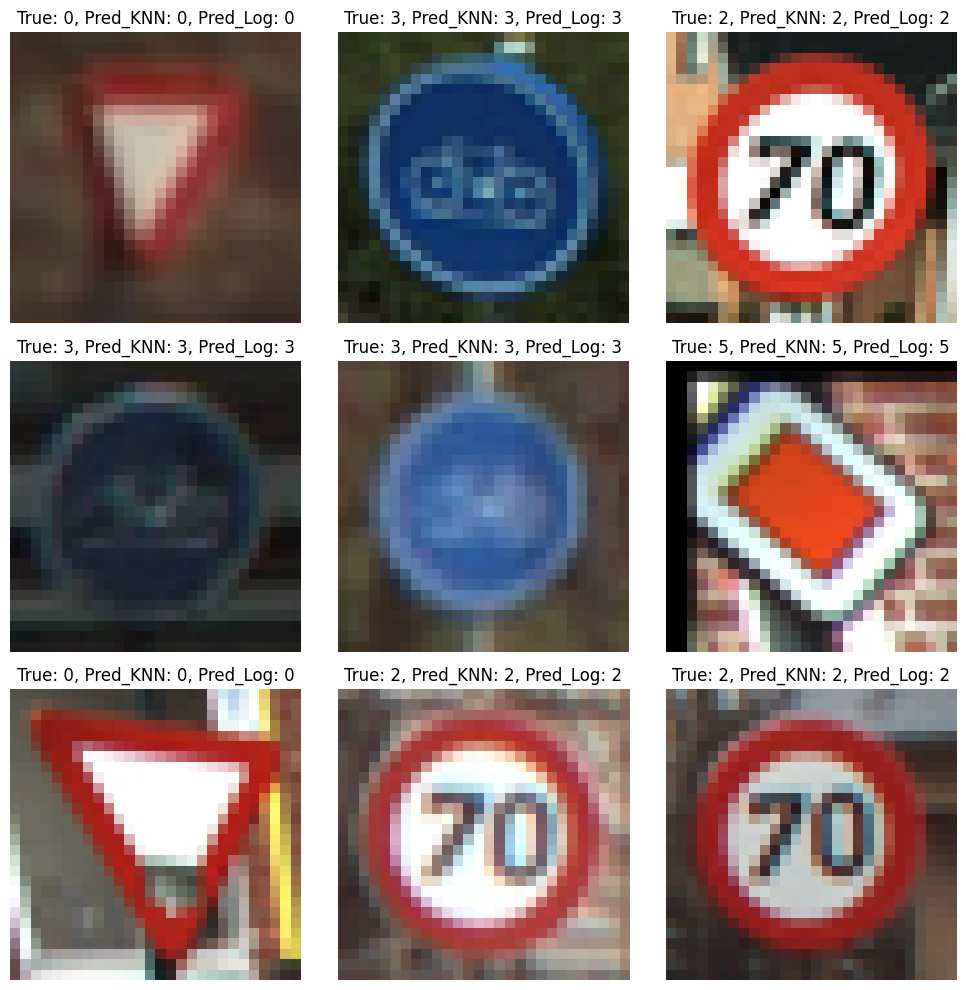

In [71]:
plt.figure(figsize=(10, 10))
for i in range(9):
    index = random.randint(0, X_test.shape[0])
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[index].reshape(image_shape))
    plt.title(f"True: {Y_test[index]}, Pred_KNN: {
              Y_pred[index]}, Pred_Log: {y_pred[index]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Compare between Logistic and KNN

## Logistic verse KNN accuracy

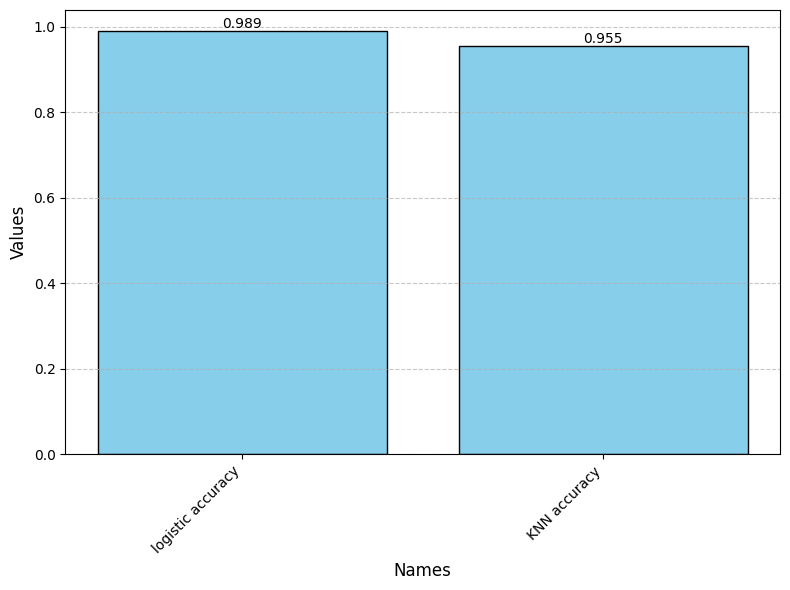

In [72]:
plot_name_values([("logistic accuracy", accuracy_score(y_pred, y_test)),
                 ("KNN accuracy", accuracy_score(Y_pred, Y_test))])

## Logistic verse KNN confusion matrix

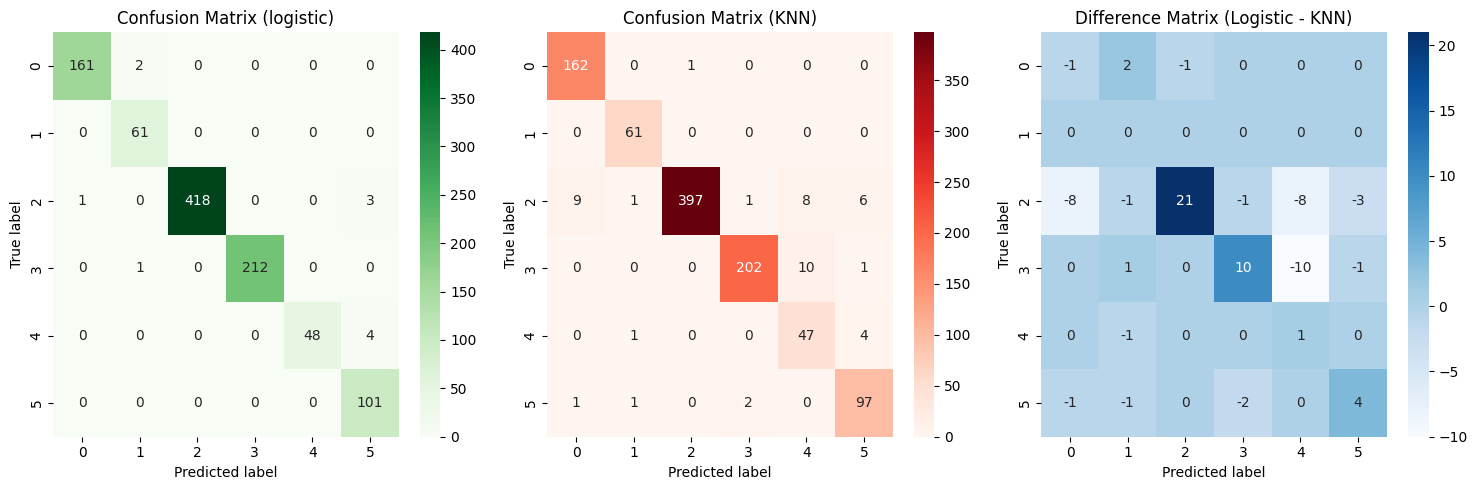

In [73]:
conf_matrix = confusion_matrix(y_test, y_pred)

cm = confusion_matrix(Y_test, Y_pred)

new_matrix = conf_matrix - cm

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', ax=axes[0])
axes[0].set_title('Confusion Matrix (logistic)')
axes[0].set_xlabel('Predicted label')
axes[0].set_ylabel('True label')

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=axes[1])
axes[1].set_title('Confusion Matrix (KNN)')
axes[1].set_xlabel('Predicted label')
axes[1].set_ylabel('True label')

sns.heatmap(new_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Difference Matrix (Logistic - KNN)')
axes[2].set_xlabel('Predicted label')
axes[2].set_ylabel('True label')

plt.tight_layout()
plt.show()

## Logistic verse KNN ROC and AUC

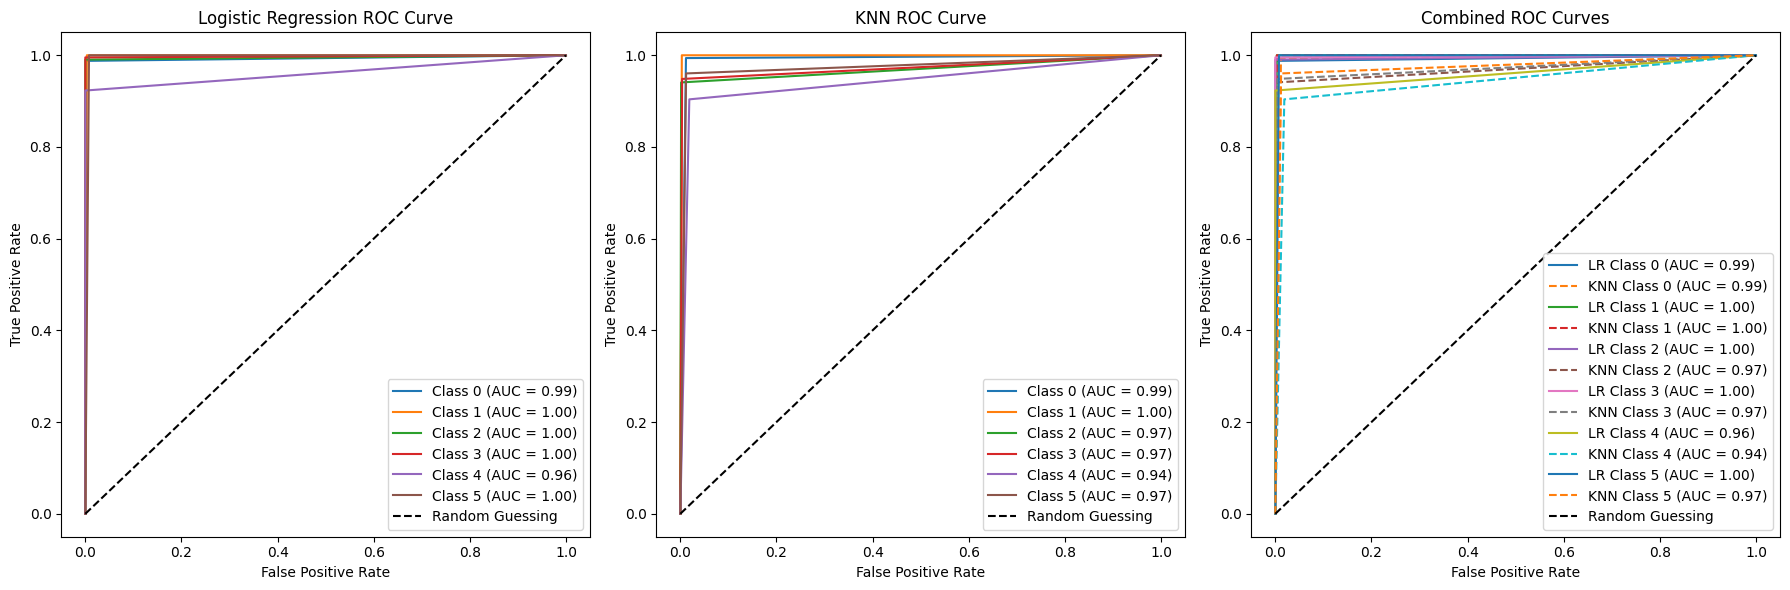

In [74]:
y_pred = model.predict(x_test)
y_test = np.array(y_test)
y_pred = np.array(y_pred)
Y_pred = knn.predict(X_test)
Y_test = np.array(Y_test)
Y_pred = np.array(Y_pred)

fpr_lr = dict()
tpr_lr = dict()
roc_auc_lr = dict()
for i in range(6):
    fpr_lr[i], tpr_lr[i], _ = roc_curve(y_test == i, y_pred == i)
    roc_auc_lr[i] = auc(fpr_lr[i], tpr_lr[i])

fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()
for i in range(6):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(Y_test == i, Y_pred == i)
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])

fig, axes = plt.subplots(1, 3, figsize=(18, 6))


axes[0].set_title('Logistic Regression ROC Curve')
for i in range(6):
    axes[0].plot(fpr_lr[i], tpr_lr[i], label=f'Class {
                 i} (AUC = {roc_auc_lr[i]:0.2f})')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Guessing')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend(loc="lower right")


axes[1].set_title('KNN ROC Curve')
for i in range(6):
    axes[1].plot(fpr_knn[i], tpr_knn[i], label=f'Class {
                 i} (AUC = {roc_auc_knn[i]:0.2f})')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Guessing')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend(loc="lower right")


axes[2].set_title('Combined ROC Curves')
for i in range(6):
    axes[2].plot(fpr_lr[i], tpr_lr[i], label=f'LR Class {
                 i} (AUC = {roc_auc_lr[i]:0.2f})')
    axes[2].plot(fpr_knn[i], tpr_knn[i], linestyle='--',
                 label=f'KNN Class {i} (AUC = {roc_auc_knn[i]:0.2f})')
axes[2].plot([0, 1], [0, 1], 'k--', label='Random Guessing')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].legend(loc="lower right")

plt.tight_layout()
plt.show()

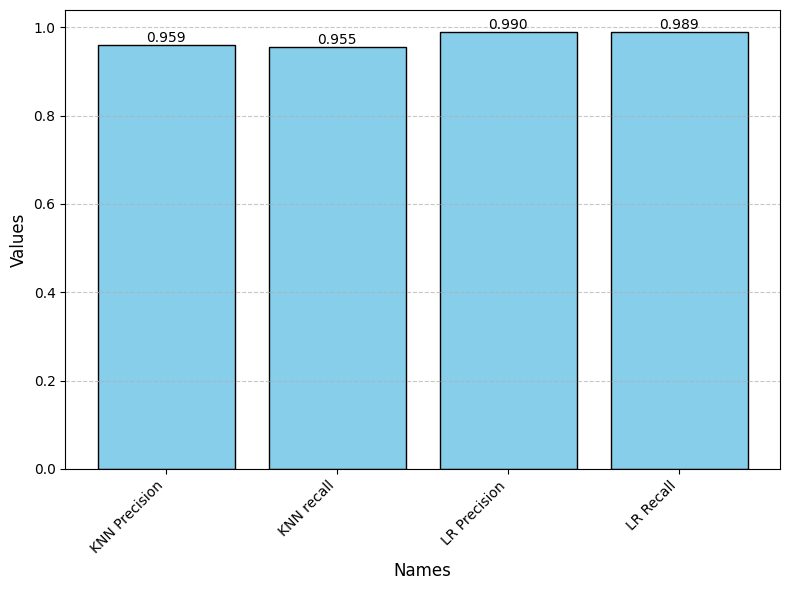

In [75]:
knn_precision = precision_score(Y_test, Y_pred, average='weighted')
knn_recall = recall_score(Y_test, Y_pred, average='weighted')

logistic_precision = precision_score(y_test, y_pred, average="weighted")
logistic_recall = recall_score(y_test, y_pred, average='weighted')

plot_name_values([("KNN Precision", knn_precision), ("KNN recall", knn_recall),
                 ("LR Precision", logistic_precision), ("LR Recall", logistic_recall)])